In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('images') if isfile(join('images', f))]

In [3]:
image_path = 'images/EAN-UPC-EAN-13 MASTER GRADE IMGB.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

In [36]:
image_path = f'images/{images_paths[10]}'#'other images/1.png'#f'images/{images_paths[22]}'

(1024, 1280, 3)


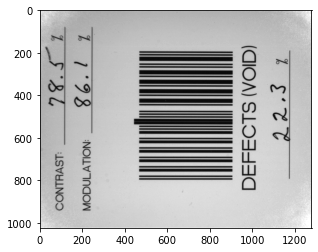

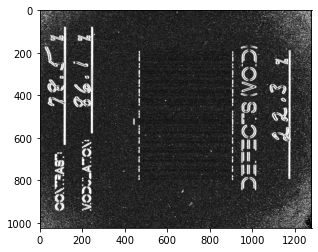

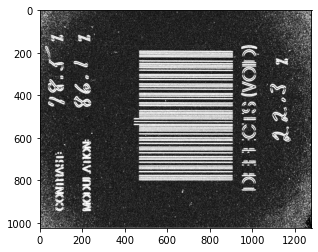

In [37]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradX), 'gray')

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradY), 'gray')

In [38]:
cv2.convertScaleAbs(gradY).sum()

97450087

In [39]:
cv2.convertScaleAbs(gradX).sum()

66371889

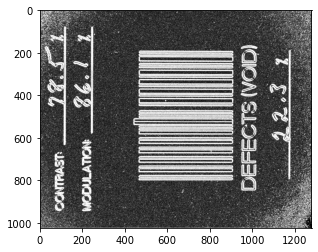

In [40]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradY, gradX)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')

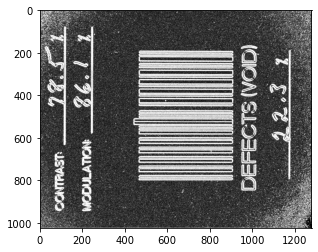

In [41]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')

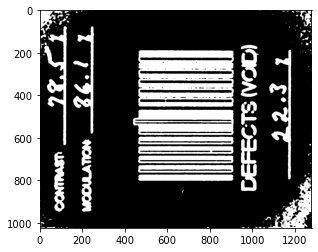

In [42]:
# Threshold, Otsu's algorithm
blurred = cv2.blur(gradient, (9, 9))
ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#thresh = 255-thresh

plt.figure()
plt.imshow(thresh, 'gray')

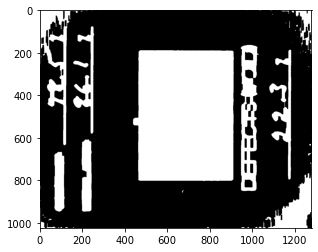

In [53]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

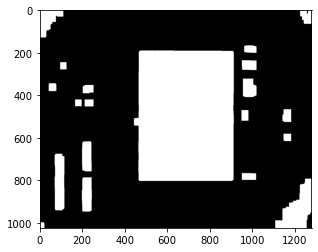

In [54]:
# Remove things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')

#opened1 = closed

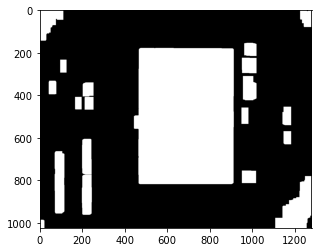

In [55]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
dilated = cv2.dilate(opened, kernel, iterations = 3)#cv2.dilate(opened1, kernel, iterations = 5)

plt.figure()
plt.imshow(dilated, 'gray')

((676.5, 497.49993896484375), (468.99993896484375, 638.9998779296875), -0.0)
[[442 816]
 [442 178]
 [911 178]
 [911 816]]


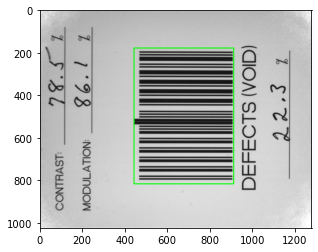

In [56]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

[(442.0, 178.0), (911.0, 178.0), (442.0, 816.0), (911.0, 816.0)]
[[442. 816.]
 [178. 442.]
 [178. 911.]
 [816. 911.]]


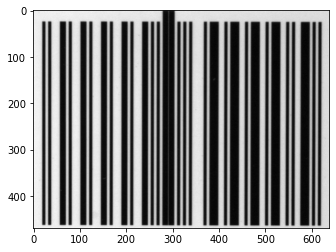

In [35]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')
print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
coordinates_destination = np.array([[destination_width-1, 0],
                                    [destination_width-1, destination_height-1],
                                    [0, 0],
                                    [0, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')